# HW4 - Template

## Import modules and setup

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb
import os
import math

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

/Users/tusharjain/opt/miniconda/envs/hw4/lib/python3.9/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline
%load_ext sql

## Parameters cell for papermill

In [3]:
token = 'BTC'
db_path = os.path.abspath("../../../Lectures/Lecture 4/data/data.db")
start_date = '2021-12-01'

## Setting up the dataframe

In [4]:
def vol_ohlc(df, lookback=3):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

In [5]:
with sqlite3.connect(db_path) as conn:
    df = (lambda x: x.assign(ts=pd.to_datetime(x['ts'])))(pd.read_sql(f'''
    SELECT * FROM ohlc
    WHERE token = '{token}' AND
          ts >= '{start_date}';
    ''', conn))
df = df.set_index('ts').sort_values(by='ts')
df.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-12-01 00:00:00,57321.41,57451.05,56814.34,56987.97,388.482022,2.218430e+07,BTC,BTC
2021-12-01 01:00:00,56998.35,57726.45,56705.06,57616.41,599.791578,3.437153e+07,BTC,BTC
2021-12-01 02:00:00,57618.55,57620.00,56972.97,57030.83,591.687200,3.387067e+07,BTC,BTC
2021-12-01 03:00:00,57029.79,57396.87,56841.01,57307.59,702.560364,4.007816e+07,BTC,BTC
2021-12-01 04:00:00,57306.55,57456.82,57026.11,57404.01,859.591535,4.920503e+07,BTC,BTC


In [6]:
df = df.assign(**{
    'drawdown':df['high'] - df['low'],
    'return':(df['close']-df['open'])*100.0/df['open'],
    'volatility':vol_ohlc(df),
    })
df['max_drawdown'] = df['drawdown'].cummax()
df.head()

,open,high,low,close,volume,volumeUSD,token,chain,drawdown,return,volatility,max_drawdown
ts,,,,,,,,,,,,
2021-12-01 00:00:00,57321.41,57451.05,56814.34,56987.97,388.482022,2.218430e+07,BTC,BTC,636.71,-0.581702,NaN,636.71
2021-12-01 01:00:00,56998.35,57726.45,56705.06,57616.41,599.791578,3.437153e+07,BTC,BTC,1021.39,1.084347,NaN,1021.39
2021-12-01 02:00:00,57618.55,57620.00,56972.97,57030.83,591.687200,3.387067e+07,BTC,BTC,647.03,-1.020019,NaN,1021.39
2021-12-01 03:00:00,57029.79,57396.87,56841.01,57307.59,702.560364,4.007816e+07,BTC,BTC,555.86,0.487114,0.144076,1021.39
2021-12-01 04:00:00,57306.55,57456.82,57026.11,57404.01,859.591535,4.920503e+07,BTC,BTC,430.71,0.170068,0.105531,1021.39


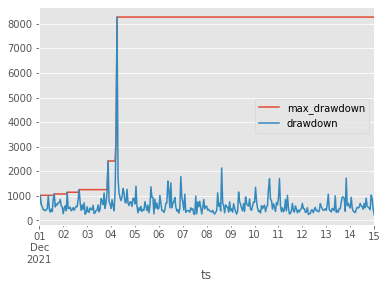

In [7]:
df[['max_drawdown', 'drawdown']].plot()
df = df.drop('drawdown', axis=1)

## Plots

In [8]:
start_days = df.between_time('00:00:00', '00:00:00').index.to_list()
end_days = start_days[1:] + [start_days[-1]]

In [9]:
colors = np.concatenate([cm.rainbow(np.linspace(0,1,7)) 
              for i in range(math.ceil(len(start_days)/7))])

In [10]:
def plot(df, ax, start_days=start_days, end_days=end_days, colors=colors, alpha=.2):
    ax.clear()
    df.plot(ax=ax)
    for start_marker, end_marker, color in zip(start_days, end_days, colors):
        ax.axvspan(start_marker, end_marker, color=color, alpha=alpha)

In [11]:
%%capture

fig, ax = plt.subplots(2, 2, figsize=(20,20))

In [12]:
plot(df[['return']], ax[0,0])
plot(df[['volume']], ax[0,1])
plot(df[['max_drawdown']], ax[1,0])
plot(df[['close']], ax[1,1])
fig.suptitle(f'Statistics for {token}');

## Output Summary and Scrapbook Glue

In [13]:
result = pd.Series({
        'avg_return': df['return'].mean(),
        'avg_volatility': df['volatility'].mean(),
        'max_drawdown': df['max_drawdown'].max(),
        'range': df.iloc[-1]['close'] - df.iloc[0]['close']}, name=token)
result

avg_return          -0.049093
avg_volatility       0.169817
max_drawdown      8275.860000
range            -8768.880000
Name: BTC, dtype: float64

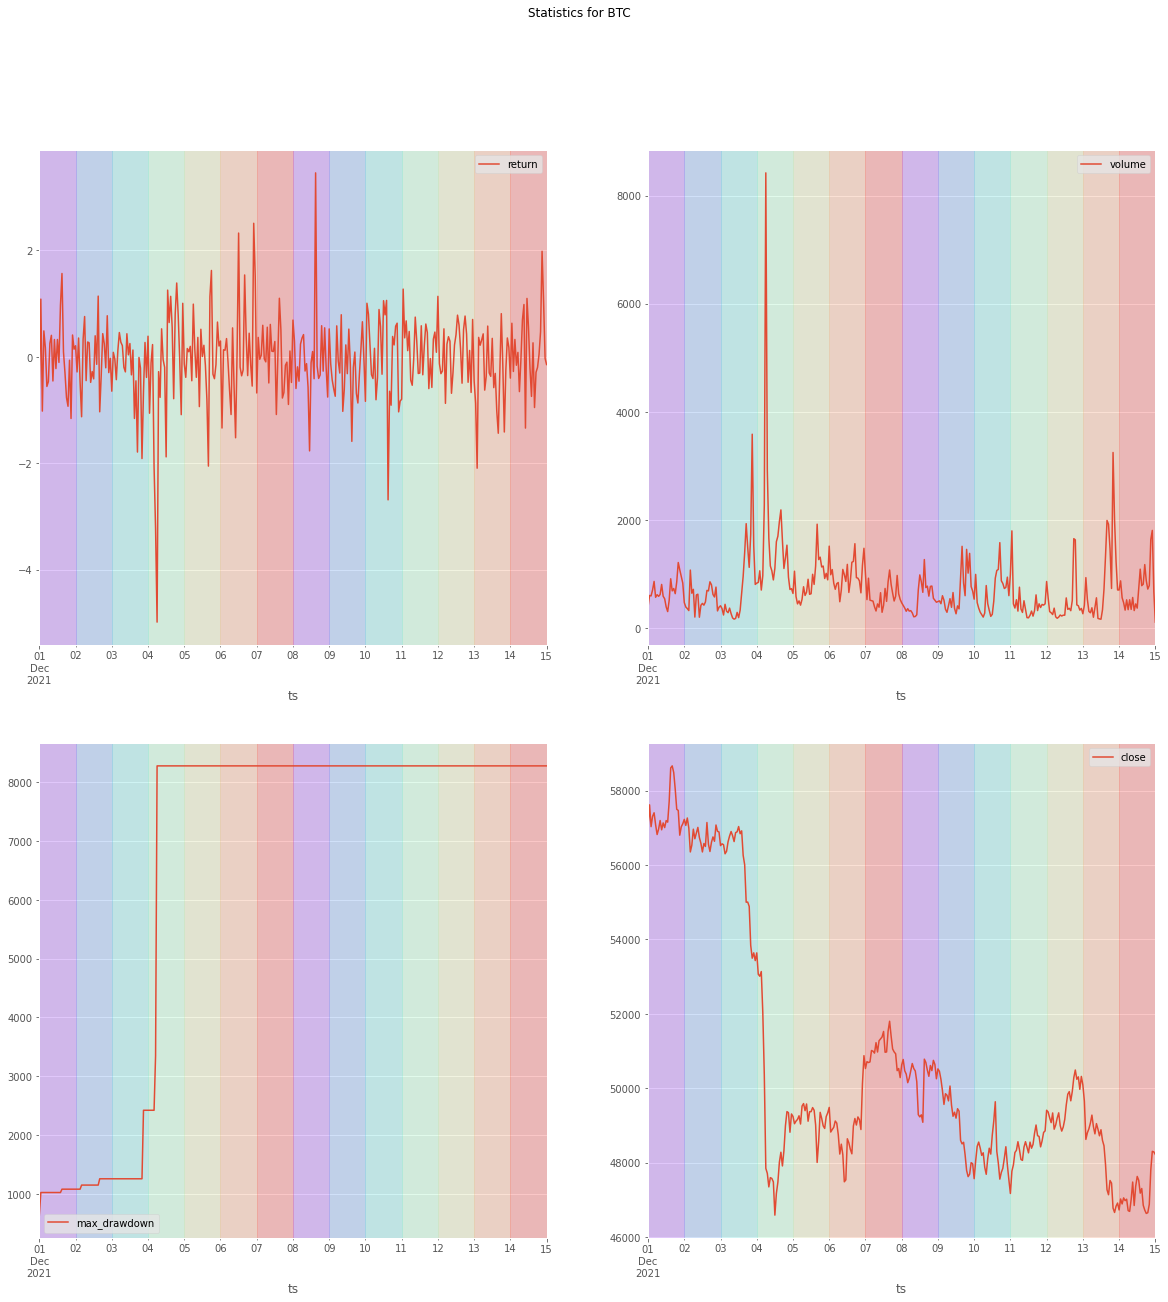

In [14]:
sb.glue('result', result.to_frame(), encoder='pandas')
sb.glue('plot', fig, encoder='display', display=True)